<br>

<br>

# This next cell contains methods for generating data for training the feature extractor and data for environments 1, 2, and 3 by adding color to the MNIST images and binarizing the image labels.

In [1]:

import numpy as np
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
import pandas as pd
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats



# Download and split MNIST data
mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:40000], mnist.targets[:40000])
mnist_test = (mnist.data[40000:], mnist.targets[40000:])
mnist_all = (mnist.data, mnist.targets)

#Shuffle the data
rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

rng_state = np.random.get_state()
np.random.shuffle(mnist_all[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_all[1].numpy())

# Splitting the data that will be used to train the feature extractor 
# into 80% train set and 20% test set
X_train = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train = mnist_all[1][:int(0.8*len(mnist_all[1]))] 
X_test = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test = mnist_all[1][int(0.8*len(mnist_all[1])):]


# used to binarize the target variable
def binarize(y, label_noise=0.):
    
    y = np.copy(y) > 4
    
    if label_noise > 0:
        y = np.logical_xor(y, np.random.binomial(1, label_noise, size=len(y)))
    
    return y.astype(int)

# used to randomly add color to the dataset used to train the feature extractor
def color_digits(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0    
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)



# used to color either the entire dataset green or the entire dataset red
def color_all_images_same_color(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
        
    if green:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.)


# Produce images for the factor model
def produce_images_for_the_factor_model(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    color = None    
    if green:
        color = np.ones(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        color = np.zeros(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)


# Used to generate environments 1, 2, and 3 by varying the distribution of color
def generate_environments(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0
    
    colored_X = colored_X.reshape(X.shape[0],-1)
    
    return {
      'images': (colored_X.astype(float) / 255.),
      'labels': y[:, None],
      'colors': color[:, None]
    }

    
    
# Used to plot colored images    
def plot_images(X, n_row=10, n_col=10, shape=(2,14,14), scale=False):
    fig = plt.figure(figsize=(n_row, n_col))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
    for ax in grid:
        index = np.random.choice(np.arange(X.shape[0]))
        img = X[index].reshape(shape)
        if scale:
            img = img - img.min()
            img /= img.max()
        img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
        img = np.moveaxis(img, 0, -1)
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

<br>

# Define, train, and evaluate the feature extractor

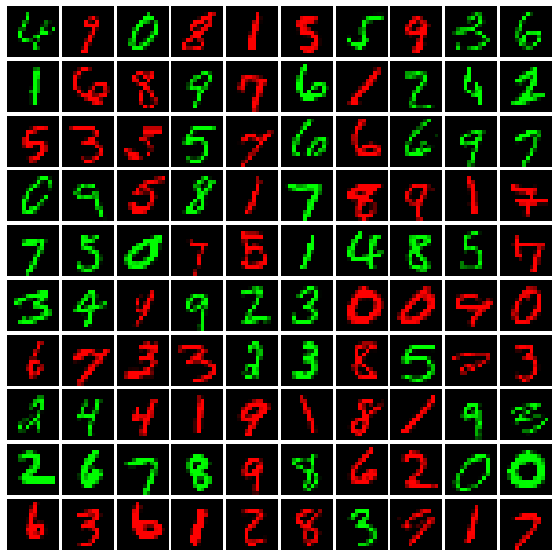

Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)
Label Accuracy:  0.9429166666666666
Color Accuracy:  1.0


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

class MLP(torch.nn.Module):

    def __init__(self, size=[2*14*14, 2]):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(size)-2):
            layers.append(torch.nn.Linear(size[i], size[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size[-2], size[-1]))
        self.net = torch.nn.Sequential(*layers)
        print(self.net)

    def forward(self, x):
        return self.net(x)

def tensor_numpy(arrays, device):
    out = []
    for a in arrays:
        out.append(torch.from_numpy(a).float().to(device))
    return out
    
    
np.random.seed(1)
label_noise = 0.
color_noise = None

y_train = binarize(y_train, label_noise=label_noise)
y_test = binarize(y_test, label_noise=label_noise)

X_train, color_train = color_digits(X_train, y_train, color_noise, downsample=True)
X_test, color_test = color_digits(X_test, y_test, color_noise, downsample=True)

plot_images(X_train)
# plot_images(X_test)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

hidden_size = [2*14*14, 50, 2]
net = MLP(hidden_size).to(device)

tr_x, tr_y, tr_c = tensor_numpy([X_train, y_train, color_train], device)
te_x, te_y, te_c = tensor_numpy([X_test, y_test, color_test], device)

bs = 256

tr_dataset = TensorDataset(tr_x, tr_y, tr_c)
tr_loader = DataLoader(tr_dataset, batch_size = bs, shuffle = True)
# te_dataset = TensorDataset(te_x, te_y, te_c)
# te_loader = DataLoader(te_dataset, batch_size = bs, shuffle = True)

loss_label = torch.nn.BCEWithLogitsLoss()
loss_color = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 10
for e in range(epoch):
    
    for x, y, c in tr_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss_y = loss_label(out[:,0], y)
        loss_c = loss_color(out[:,1], c)
        loss = loss_y + loss_c
        
        loss.backward()
        optimizer.step()
        
            
with torch.no_grad():
    test_preds = 1*(net(te_x).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(y_test, test_preds[:,0])
    acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
    print('Color Accuracy: ', acc_c)

<br>

# Use the trained feature extractor to extract features from data that will be used to train and test our classifiers

In [3]:
label_noise = 0.
color_noise = None


env1_X_train = mnist_train[0][::2]
env1_y_train = binarize(mnist_train[1][::2], label_noise=label_noise)

env2_X_train = mnist_train[0][1::2]
env2_y_train = binarize(mnist_train[1][1::2], label_noise=label_noise)

env3_X_train = mnist_test[0]
env3_y_train = binarize(mnist_test[1], label_noise=label_noise)

envs = [
generate_environments(env1_X_train, env1_y_train, 0.1),
generate_environments(env2_X_train, env2_y_train, 0.05),
generate_environments(env3_X_train, env3_y_train, 0.9)
]


class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()   
        net.eval()
        self.children_list = []
        for n,c in net.named_children():
            self.children_list.append(c)
            
        print("Printing all the trained model layers")
        print(self.children_list)
        self.children_list = self.children_list[0][:2]
        print("Printing model layers after dropping the output layer for feature extraction")    
        print(self.children_list)
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x


def extract_features(model,x,y, device = 'cpu'):
    extracted_features = []
    labels = []   
    with torch.no_grad():
        x = x.to(device)
        extracted_features = model(x.float())
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features_df = pd.DataFrame(extracted_features.numpy())
    extracted_features_df["target"] = y.cpu().numpy()
    return extracted_features_df



train_envs_1_and_2_inputs = torch.cat((torch.from_numpy(envs[0]['images']), torch.from_numpy(envs[1]['images'])), 0)
train_envs_1_and_2_targets = torch.cat((torch.from_numpy(envs[0]['labels']), torch.from_numpy(envs[1]['labels'])), 0)

print("Combined environments 1 and 2 data size - used to train our final prediction models")
print(len(train_envs_1_and_2_inputs))
print(len(train_envs_1_and_2_targets))

test_inputs =torch.from_numpy(envs[2]['images'])
test_targets =torch.from_numpy(envs[2]['labels'])

print("Environment 3 data size - used to test our final prediction models")
print(len(test_inputs))
print(len(test_targets))

feature_extractor = feature_extractor()

train_extracted_features_df = extract_features(feature_extractor,train_envs_1_and_2_inputs, train_envs_1_and_2_targets)
test_extracted_features_df = extract_features(feature_extractor,test_inputs, test_targets)


print("Printing the extracted features - first train features followed by test features shape/size!!!")
# print(train_extracted_features_df)
print(train_extracted_features_df.shape)
# print(test_extracted_features_df)
print(test_extracted_features_df.shape)


Combined environments 1 and 2 data size - used to train our final prediction models
40000
40000
Environment 3 data size - used to test our final prediction models
20000
20000
Printing all the trained model layers
[Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)]
Printing model layers after dropping the output layer for feature extraction
Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
)
Printing the extracted features - first train features followed by test features shape/size!!!
(40000, 51)
(20000, 51)


In [4]:
# envs = [
# generate_environments(env1_X_train, env1_y_train, 0.2),
# generate_environments(env2_X_train, env2_y_train, 0.4),
# generate_environments(env3_X_train, env3_y_train, 0.9)
# ]

<br>

<br>

# Transforming the extracted image features using a factor model

# Preparing the features that we will need to obtain F and L for.

All images colored green
Color labels for green:
[1 1 1 ... 1 1 1]


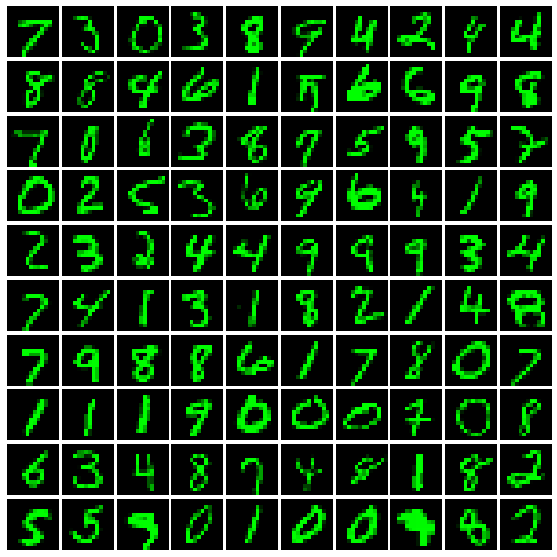

All images colored red
Color labels for red:
[0 0 0 ... 0 0 0]


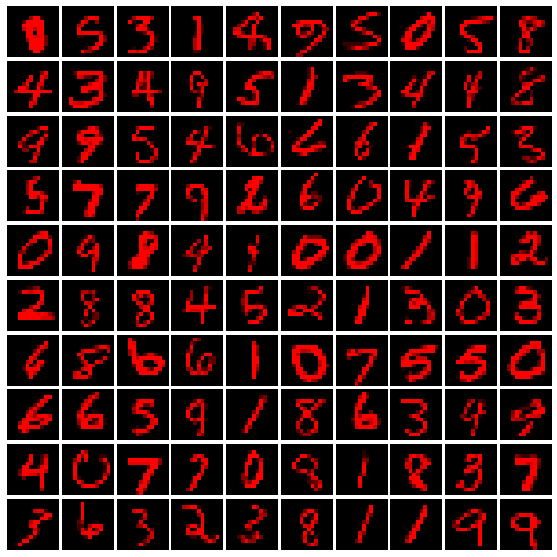

Z shape
(96000, 50)
Z_test shape
(24000, 50)
Z_test_green shape
(12000, 50)
Z_test_red shape
(12000, 50)


In [5]:
X_train_ = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train_ = mnist_all[1][:int(0.8*len(mnist_all[1]))]

X_test_ = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test_ = mnist_all[1][int(0.8*len(mnist_all[1])):]

y_train_ = binarize(y_train_, label_noise=label_noise)
y_test_ = binarize(y_test_, label_noise=label_noise)

green_images, color_green = produce_images_for_the_factor_model(X_train_, green=True)

red_images, color_red = produce_images_for_the_factor_model(X_train_, green=False)

green_and_red_images = np.concatenate((green_images, red_images), axis=0)
color = np.concatenate((color_green, color_red), axis=None)
label_train = np.concatenate((y_train_, y_train_), axis=None)


green_images_test, color_green_test = produce_images_for_the_factor_model(X_test_, green=True)

red_images_test, color_red_test = produce_images_for_the_factor_model(X_test_, green=False)

green_and_red_images_test = np.concatenate((green_images_test, red_images_test), axis=0)
color_test = np.concatenate((color_green_test, color_red_test), axis=None)
label_test = np.concatenate((y_test_, y_test_), axis=None)



print("All images colored green")
print("Color labels for green:")
print(color_green)
plot_images(green_images)


print("All images colored red")
print("Color labels for red:")
print(color_red)
plot_images(red_images)

# print("All images red and green combined so each image has a duplicate in opposite color")
# print("Color labels:")
# print(color)
# plot_images(green_and_red_images)



# print("Green test images")
# print("Color labels for green test images:")
# print(color_green_test)
# plot_images(green_images_test)


# print("Red test images")
# print("Color labels for red test images:")
# print(color_red_test)
# plot_images(red_images_test)

# print("All test images red and green combined so each image has a duplicate in opposite color")
# print("Test color labels:")
# print(color_test)
# plot_images(green_and_red_images_test)






# extract features from green and red train images
Z = extract_features(feature_extractor,torch.from_numpy(green_and_red_images), 
                                        torch.from_numpy(color)).to_numpy()[:, :-1]

# extract features from green and red test images
Z_test = extract_features(feature_extractor,torch.from_numpy(green_and_red_images_test), 
                                        torch.from_numpy(color_test)).to_numpy()[:, :-1]


# extract features from green test images
Z_test_green = extract_features(feature_extractor,torch.from_numpy(green_images_test), 
                                        torch.from_numpy(color_green_test)).to_numpy()[:, :-1]

# extract features from red test images
Z_test_red = extract_features(feature_extractor,torch.from_numpy(red_images_test), 
                                        torch.from_numpy(color_red_test)).to_numpy()[:, :-1]

# Features from images in environments 1, 2, and 3. Environments 1 and 2 are combined to be used for training. 
Z_envs_1_and_2 = train_extracted_features_df.to_numpy()[:, :-1]
Z_env3 = test_extracted_features_df.to_numpy()[:, :-1]


print("Z shape")
print(Z.shape)

print("Z_test shape")
print(Z_test.shape)

print("Z_test_green shape")
print(Z_test_green.shape)

print("Z_test_red shape")
print(Z_test_red.shape)




# Training the factor model to obtain F and L.

In [6]:
import torch
from torch.autograd import Variable

dtype = torch.FloatTensor
n = Z.shape[0]
d = Z.shape[1]
k = int(Z.shape[1]*0.2) # 20% of original number of features

F1 = Variable(torch.randn(n,1).type(dtype), requires_grad=False)
F1[color.astype(bool)] = -1
F1[~color.astype(bool)] = 1
print("Shape of F1")
print(F1.shape)

F2 = Variable(torch.randn(n, k-1).type(dtype), requires_grad=True)

print("Shape of F2")
print(F2.shape)


F = torch.cat((F1, F2), 1)
print()
print("Shape of initial F")
print(F.shape)

L = Variable(torch.randn(k, d).type(dtype), requires_grad=True)

print()
print("Shape of initial L")
print(L.shape)


# Zero out the diagonal of the matrix
def get_off_diagonal_elements(M):
    res = M.clone()
    res.diagonal(dim1=-1, dim2=-2).zero_()
    return res


optimizer = torch.optim.Adam([F2, L], lr=0.01)

for epoch in range(100000):        
    optimizer.zero_grad() 
    F = torch.cat((F1, F2), 1)
#     reconstruction_loss = torch.square(torch.linalg.matrix_norm(torch.sub(torch.from_numpy(Z), torch.matmul(F, L)))) 
    reconstruction_loss = torch.sum(torch.square(torch.from_numpy(Z)-torch.matmul(F, L)))
    cov_F_off_diagonals_sum = torch.sum(torch.abs(get_off_diagonal_elements(torch.cov(F.T))))
    loss = reconstruction_loss + cov_F_off_diagonals_sum
    if epoch % 10000 == 0: 
        print("reconstruction loss")
        print(reconstruction_loss)
        print("off-diag loss")
        print(cov_F_off_diagonals_sum)
    loss.backward()
    optimizer.step()
    
    
print()
print("Final F shape")
print(F.shape)    

print()
print("Final L shape")
print(L.shape)


Shape of F1
torch.Size([96000, 1])
Shape of F2
torch.Size([96000, 9])

Shape of initial F
torch.Size([96000, 10])

Shape of initial L
torch.Size([10, 50])
reconstruction loss
tensor(62095154.9072, dtype=torch.float64, grad_fn=<SumBackward0>)
off-diag loss
tensor(0.2405, grad_fn=<SumBackward0>)
reconstruction loss
tensor(451509.1537, dtype=torch.float64, grad_fn=<SumBackward0>)
off-diag loss
tensor(14.9683, grad_fn=<SumBackward0>)
reconstruction loss
tensor(451517.7561, dtype=torch.float64, grad_fn=<SumBackward0>)
off-diag loss
tensor(11.8617, grad_fn=<SumBackward0>)
reconstruction loss
tensor(451501.9685, dtype=torch.float64, grad_fn=<SumBackward0>)
off-diag loss
tensor(9.7781, grad_fn=<SumBackward0>)
reconstruction loss
tensor(451538.3867, dtype=torch.float64, grad_fn=<SumBackward0>)
off-diag loss
tensor(8.3145, grad_fn=<SumBackward0>)
reconstruction loss
tensor(451507.6117, dtype=torch.float64, grad_fn=<SumBackward0>)
off-diag loss
tensor(7.2105, grad_fn=<SumBackward0>)
reconstructio

# Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.

In [7]:
# Documentation of np.linalg.lstsq: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
F_test = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test.transpose(), rcond=None)[0].transpose())
F_test_green = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_green.transpose(), rcond=None)[0].transpose())
F_test_red = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_red.transpose(), rcond=None)[0].transpose())

F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
F_env3 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_env3.transpose(), rcond=None)[0].transpose())



print("F_test shape")
print(F_test.shape)

print("F_test_green shape")
print(F_test_green.shape)

print("F_test_red shape")
print(F_test_red.shape)

print("F_envs_1_and_2 shape")
print(F_envs_1_and_2.shape)

print("F_env3 shape")
print(F_env3.shape)


F_test shape
torch.Size([24000, 10])
F_test_green shape
torch.Size([12000, 10])
F_test_red shape
torch.Size([12000, 10])
F_envs_1_and_2 shape
torch.Size([40000, 10])
F_env3 shape
torch.Size([20000, 10])


# Correlation Matrices

## Correlation Matrix for F

In [8]:
pd.DataFrame(torch.corrcoef(F.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000172,-0.064462,0.614129,0.000082,0.244794,-0.133691,-6.192257e-04,4.985958e-05,-0.000022
1,0.000172,1.000000,0.187750,-0.127877,-0.035203,0.000089,-0.002499,2.303719e-01,5.125841e-01,0.215208
2,-0.064462,0.187750,1.000000,0.232027,-0.000013,-0.311650,-0.180595,-1.438478e-01,2.054616e-05,-0.062552
3,0.614129,-0.127877,0.232027,1.000000,0.442801,-0.000707,0.051430,4.756486e-04,6.553096e-05,0.122221
4,0.000082,-0.035203,-0.000013,0.442801,1.000000,-0.415209,-0.000114,4.237967e-01,1.230105e-01,0.019123
5,0.244794,0.000089,-0.311650,-0.000707,-0.415209,1.000000,0.001083,2.459894e-02,5.130166e-02,-0.077563
6,-0.133691,-0.002499,-0.180595,0.051430,-0.000114,0.001083,1.000000,-4.429800e-01,3.181162e-01,0.472116
7,-0.000619,0.230372,-0.143848,0.000476,0.423797,0.024599,-0.442980,1.000000e+00,4.037965e-07,0.016056
8,0.000050,0.512584,0.000021,0.000066,0.123010,0.051302,0.318116,4.037964e-07,1.000000e+00,-0.047276
9,-0.000022,0.215208,-0.062552,0.122221,0.019123,-0.077563,0.472116,1.605636e-02,-4.727553e-02,1.000000


## Correlation Matrix for F_test

In [9]:
pd.DataFrame(torch.corrcoef(F_test.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.131906,-0.085055,0.322771,-0.245471,-0.014909,-0.106950,-0.202754,-0.276541,0.111386
1,-0.131906,1.000000,0.191800,0.017663,0.140459,0.146906,-0.005232,0.336899,0.568892,0.126336
2,-0.085055,0.191800,1.000000,0.233447,0.029894,-0.258372,-0.177535,-0.107086,0.032544,-0.071890
3,0.322771,0.017663,0.233447,1.000000,0.554036,0.197026,0.039841,0.182236,0.255305,0.003959
4,-0.245471,0.140459,0.029894,0.554036,1.000000,-0.044749,-0.006667,0.558029,0.424070,-0.120373
5,-0.014909,0.146906,-0.258372,0.197026,-0.044749,1.000000,-0.006804,0.244010,0.337422,-0.193017
6,-0.106950,-0.005232,-0.177535,0.039841,-0.006667,-0.006804,1.000000,-0.404334,0.234551,0.462165
7,-0.202754,0.336899,-0.107086,0.182236,0.558029,0.244010,-0.404334,1.000000,0.289947,-0.108620
8,-0.276541,0.568892,0.032544,0.255305,0.424070,0.337422,0.234551,0.289947,1.000000,-0.198845
9,0.111386,0.126336,-0.071890,0.003959,-0.120373,-0.193017,0.462165,-0.108620,-0.198845,1.000000


## Correlation Matrix for F_test_green

In [10]:
pd.DataFrame(torch.corrcoef(F_test_green.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.386836,0.068285,-0.503321,-0.552422,-0.400786,-0.154359,-0.291509,-0.449412,0.300179
1,-0.386836,1.000000,0.207865,-0.162027,0.107682,-0.163761,-0.279851,0.219042,0.633186,-0.892964
2,0.068285,0.207865,1.000000,0.439850,0.134821,-0.506465,0.015057,-0.198047,0.074024,0.039002
3,-0.503321,-0.162027,0.439850,1.000000,0.680252,0.061873,0.227550,0.301224,0.156092,0.394252
4,-0.552422,0.107682,0.134821,0.680252,1.000000,-0.285429,0.184167,0.602819,0.287892,0.140901
5,-0.400786,-0.163761,-0.506465,0.061873,-0.285429,1.000000,0.171668,-0.115727,0.158029,-0.079639
6,-0.154359,-0.279851,0.015057,0.227550,0.184167,0.171668,1.000000,-0.544419,0.385839,0.405065
7,-0.291509,0.219042,-0.198047,0.301224,0.602819,-0.115727,-0.544419,1.000000,0.060621,-0.185437
8,-0.449412,0.633186,0.074024,0.156092,0.287892,0.158029,0.385839,0.060621,1.000000,-0.514649
9,0.300179,-0.892964,0.039002,0.394252,0.140901,-0.079639,0.405065,-0.185437,-0.514649,1.000000


## Correlation Matrix for F_test_red

In [11]:
pd.DataFrame(torch.corrcoef(F_test_red.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.230988,-0.207818,-0.478136,-0.543121,-0.616644,0.203112,-0.707194,-0.858176,0.260757
1,-0.230988,1.000000,0.189685,0.238982,0.199913,0.465751,0.241339,0.513394,0.530470,0.545468
2,-0.207818,0.189685,1.000000,0.112188,-0.199364,0.180395,-0.501398,0.079464,-0.038078,-0.165452
3,-0.478136,0.238982,0.112188,1.000000,0.659872,0.126027,-0.005151,0.039830,0.582814,-0.272046
4,-0.543121,0.199913,-0.199364,0.659872,1.000000,0.412746,-0.338564,0.453765,0.702254,-0.361893
5,-0.616644,0.465751,0.180395,0.126027,0.412746,1.000000,-0.173539,0.913070,0.630693,-0.296954
6,0.203112,0.241339,-0.501398,-0.005151,-0.338564,-0.173539,1.000000,-0.195683,0.033304,0.549999
7,-0.707194,0.513394,0.079464,0.039830,0.453765,0.913070,-0.195683,1.000000,0.723423,-0.079926
8,-0.858176,0.530470,-0.038078,0.582814,0.702254,0.630693,0.033304,0.723423,1.000000,-0.033521
9,0.260757,0.545468,-0.165452,-0.272046,-0.361893,-0.296954,0.549999,-0.079926,-0.033521,1.000000


## Correlation Matrix for F_envs_1_and_2

In [12]:
pd.DataFrame(torch.corrcoef(F_envs_1_and_2.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.334170,-0.660460,0.306821,0.009953,-0.041911,-0.013760,-0.019579,-0.236520,0.140371
1,-0.334170,1.000000,0.228169,0.040395,0.155992,0.130605,0.235201,0.335552,0.558363,0.434857
2,-0.660460,0.228169,1.000000,-0.099514,0.056017,-0.355032,-0.306996,0.036395,-0.022225,-0.131730
3,0.306821,0.040395,-0.099514,1.000000,0.748130,0.109283,-0.147991,0.398712,0.425133,-0.113359
4,0.009953,0.155992,0.056017,0.748130,1.000000,-0.176741,-0.312449,0.641581,0.326557,-0.160006
5,-0.041911,0.130605,-0.355032,0.109283,-0.176741,1.000000,0.300205,0.030766,0.564650,-0.210515
6,-0.013760,0.235201,-0.306996,-0.147991,-0.312449,0.300205,1.000000,-0.301650,0.221335,0.502200
7,-0.019579,0.335552,0.036395,0.398712,0.641581,0.030766,-0.301650,1.000000,0.316553,0.014060
8,-0.236520,0.558363,-0.022225,0.425133,0.326557,0.564650,0.221335,0.316553,1.000000,-0.075059
9,0.140371,0.434857,-0.131730,-0.113359,-0.160006,-0.210515,0.502200,0.014060,-0.075059,1.000000


## Correlation Matrix for F_env3

In [13]:
pd.DataFrame(torch.corrcoef(F_env3.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.059298,0.455894,0.338597,-0.453152,0.005354,-0.185853,-0.356245,-0.322088,0.098157
1,0.059298,1.000000,0.173727,-0.003115,0.113638,0.149168,-0.210219,0.312897,0.599550,-0.381199
2,0.455894,0.173727,1.000000,0.491053,0.002341,-0.111207,-0.077617,-0.220640,0.083451,0.011122
3,0.338597,-0.003115,0.491053,1.000000,0.420591,0.294913,0.152014,0.044522,0.139486,0.142252
4,-0.453152,0.113638,0.002341,0.420591,1.000000,0.062301,0.211531,0.495765,0.485283,-0.074437
5,0.005354,0.149168,-0.111207,0.294913,0.062301,1.000000,-0.266792,0.404063,0.143642,-0.176943
6,-0.185853,-0.210219,-0.077617,0.152014,0.211531,-0.266792,1.000000,-0.501175,0.250146,0.452836
7,-0.356245,0.312897,-0.220640,0.044522,0.495765,0.404063,-0.501175,1.000000,0.260326,-0.284163
8,-0.322088,0.599550,0.083451,0.139486,0.485283,0.143642,0.250146,0.260326,1.000000,-0.374920
9,0.098157,-0.381199,0.011122,0.142252,-0.074437,-0.176943,0.452836,-0.284163,-0.374920,1.000000


# Histograms

Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,2.235136,0.199504,0.011606,0.154928,0.048745,0.056388,0.959485,0.842500,0.803846,0.065789
1,1.016709,0.246600,0.123409,1.555369,0.673521,1.271880,0.115760,0.498241,1.594328,0.694670
2,1.563475,1.703400,0.359809,1.964983,0.989869,0.492809,0.842758,0.171843,0.521878,1.286190
3,1.488528,2.447859,0.045179,1.128861,0.006800,0.040372,0.291667,1.405803,1.734909,0.719593
4,3.016383,0.760472,0.444980,0.805264,1.460091,0.413958,0.061618,0.783275,2.236787,0.376346


Histogram for F Test feature  0


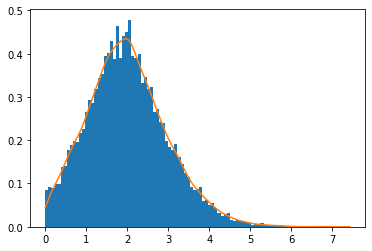

Histogram for F Test feature  1


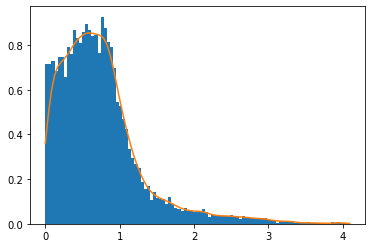

Histogram for F Test feature  2


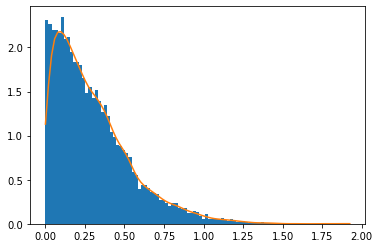

Histogram for F Test feature  3


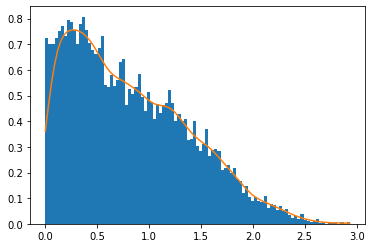

Histogram for F Test feature  4


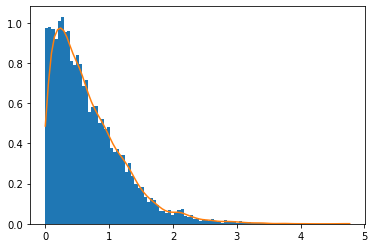

Histogram for F Test feature  5


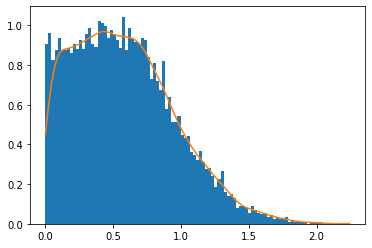

Histogram for F Test feature  6


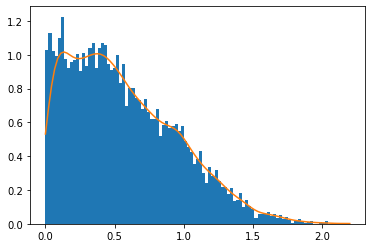

Histogram for F Test feature  7


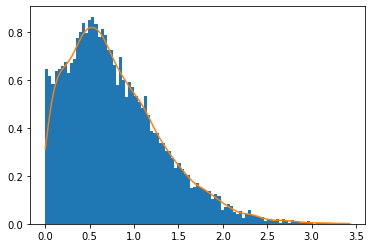

Histogram for F Test feature  8


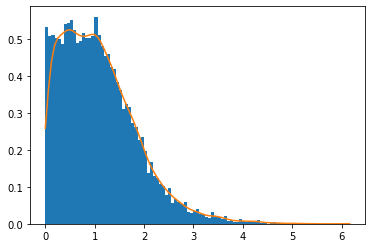

Histogram for F Test feature  9


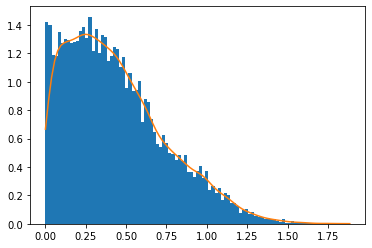

In [15]:
# the difference between F_test_green and F_test_red
delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

print("Printing the delta matrix")
delta_matrix_df = pd.DataFrame(delta_matrix)
display(delta_matrix_df.head())

# Plotting the histograms for each feature in the delta matrix # 100 bins
for i in range(len(delta_matrix_df.columns)): 
    print("Histogram for F Test feature ", i)    
    feature = delta_matrix_df.iloc[:,i].values
    density = stats.gaussian_kde(feature)
    n, x, _ = plt.hist(feature, bins=np.linspace(np.amin(delta_matrix_df.iloc[:,i]), np.amax(delta_matrix_df.iloc[:,i]), 100), 
                       histtype='bar', density=True)  
    plt.plot(x, density(x))
    plt.show()


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including color - Environment Shift Present - Logistic Regression

In [21]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


X_torch_train = F_envs_1_and_2
X_torch_test = F_env3
X_torch_test_within = F_envs_1_and_2

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))




Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])
Logistic Regression Accuracy within training data:  0.972475
Logistic Regression Accuracy on test data:  0.7974


/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except color - Environment Shift Present - Logistic Regression

In [36]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


# X_torch_train = F_envs_1_and_2[:,1:]
# X_torch_test = F_env3[:,1:]
# X_torch_test_within = F_envs_1_and_2[:,1:]

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


# print("Printing the shape of the input!")
# print(X_torch_train.shape)

# print("Printing the shape of the target!")
# print(targets_torch_train.shape)

for i in range(F_envs_1_and_2.detach().numpy().shape[1]-1):
    print("Accuracy for without feature ",i)
    temp_F_test=F_test.detach().numpy().copy()
    temp_F_test = np.delete(temp_F_test, i, 1)
    
    X_torch_train = F_envs_1_and_2.detach().numpy().copy()
    X_torch_test = F_env3.detach().numpy().copy()
    X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()
    
    X_torch_train = np.delete(X_torch_train, i, 1)
    X_torch_test = np.delete(X_torch_test, i, 1)
    X_torch_test_within = np.delete(X_torch_test_within, i, 1)


    logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

    print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
    print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.961425
Logistic Regression Accuracy on test data:  0.82575
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.9648
Logistic Regression Accuracy on test data:  0.7228
Accuracy for without feature  2


/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948825
Logistic Regression Accuracy on test data:  0.5116
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.972525
Logistic Regression Accuracy on test data:  0.79415
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.969875
Logistic Regression Accuracy on test data:  0.7706
Accuracy for without feature  5


/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970275
Logistic Regression Accuracy on test data:  0.7707
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.972
Logistic Regression Accuracy on test data:  0.79485
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.97225
Logistic Regression Accuracy on test data:  0.79785
Accuracy for without feature  8
Logistic Regression Accuracy within training data:  0.964325
Logistic Regression Accuracy on test data:  0.7313


/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Predicting label using all F_train and F_test features including color - No Environment Shift (Logistic Regression)

In [18]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F
X_torch_test = F_test
X_torch_test_within = F

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))



Printing the shape of the input!
torch.Size([96000, 10])
Printing the shape of the target!
torch.Size([96000, 1])


/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94003125
Logistic Regression Accuracy on test data:  0.938875



# Predicting Label Using all F_train and F_test Features Except Color - No Environment Shift (Logistic Regression)

In [19]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F[:,1:]
X_torch_test = F_test[:,1:]
X_torch_test_within = F[:,1:]

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))


Printing the shape of the input!
torch.Size([96000, 9])
Printing the shape of the target!
torch.Size([96000, 1])


/Users/ibmuser/opt/anaconda3/envs/causal_invariance_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9385729166666666
Logistic Regression Accuracy on test data:  0.9388333333333333


In [20]:
# F_test

tensor([[-1.0567,  0.5538,  0.0996,  ..., -0.9744, -0.0660, -0.3035],
        [-0.0986,  0.6698,  0.2720,  ..., -0.8301, -1.6123, -0.2641],
        [-0.5372,  1.0459, -0.5711,  ..., -0.5105, -0.1048, -0.6865],
        ...,
        [ 1.3087,  0.8609, -0.5011,  ..., -0.5313, -0.0482, -0.4742],
        [ 0.6379,  0.3833, -0.4260,  ..., -0.0406, -0.0712, -0.1356],
        [ 0.5875,  0.8668,  0.0262,  ..., -0.2121, -0.0301, -0.2369]],
       dtype=torch.float64)